# CSX46 Homework 1

The human metabolic network is made available in edge-list format in a two-column tab-delimited text file `shared/hsmetnet.txt`.  In case you want to check that you have a complete and uncorrupted version of the file, here is it's MD5 checksum: `50bc7295c1f727cdc5867e4853a27583`. An example of the `hsmetnet.txt` file format is shown here:
```
alkylated DNA   REACTION1
REACTION1       DNAn
REACTION1       alkylated nucleobase
acetyl-CoA      REACTION2
1-alkyl-2-lyso-sn-glycero-3-phosphocholine      REACTION2
REACTION2       1-alkyl-2-acetyl-sn-glycero-3-phosphocholine
REACTION2       coenzyme A
deoxyribonucleoside triphosphate        REACTION3
(deoxynucleotides)(n)   REACTION3
```
You will see that there are two types of nodes; nodes that start with `REACTION` and nodes that do not. The former represent chemical *reactions*, and the latter represent *metabolites*. This graph is directed, so the ordering of the nodes is important; a row of the form
```
some-metabolite    REACTION523
```
is saying that metabolite `some-metabolite` is an *input* to (i.e., a reactant for) reaction `REACTION523`. Conversely, a row of the form
```
REACTION634    another-metabolite
```
is saying that metabolite `another-metabolite` is an *output* of (i.e., a product of) reaction `REACTION634`. A graph with two classes of nodes (and for which the only allowed edges are *between* nodes of the two classes, never *among* nodes of a single class) is called *bipartite*. So in this homework assignment we will be analyzing the human metabolic network as a bipartite graph.

You will need to submit your homework assignment as either a Jupyter notebook (preferred) or a PDF of a report showing both code *and* results from running the code. 

Your first step is to read in the metabolic network as an edge-list and make an `igraph` object from it

(hint: use `read.table` and `igraph::graph_from_data_frame`)

In [1]:
suppressPackageStartupMessages(library(igraph))
bipartite_df <- read.table("shared/hsmetnet.txt",
                           sep="\t",
                           quote="",
                           header=FALSE,
                           comment.char="",
                           stringsAsFactors=FALSE)

bipartite_graph <- graph_from_data_frame(bipartite_df,
                                        directed=TRUE)


Next, you will want to construct a list of the names of all vertices and construct a list of indexes of vertices that are metabolites

(hint: use `V`, `grep`, and `setdiff`)

In [2]:
vertex_names <- V(bipartite_graph)
N <- length(vertex_names)
reaction_inds <- grep("REACTION", vertex_names$name)
metabolite_inds <- setdiff(1:N, reaction_inds)

Question: *How many distinct metabolites are there in the graph? How many reactions? How many edges are there?* 

(hint: use `sprintf`, `length` and `nrow`)

In [3]:
print(sprintf("Number of metabolites: %d", length(metabolite_inds)))
print(sprintf("Number of reactions: %d", length(reaction_inds)))
print(sprintf("Number of edges: %d", nrow(bipartite_df)))

[1] "Number of metabolites: 2340"
[1] "Number of reactions: 5539"
[1] "Number of edges: 19708"


Question* What are the top six metabolites in terms of vertex degree in the graph?* 

(hint: use `degree`, `sort`, and `head`)

In [4]:
metabolite_degrees <- degree(bipartite_graph)[metabolite_inds]
print(head(sort(metabolite_degrees, decreasing=TRUE)))

                                       ATP 
                                      1202 
                                       ADP 
                                       967 
                                 phosphate 
                                       562 
                                   peptide 
                                       456 
[protein] (L-serine/L-threonine) phosphate 
                                       383 
          [protein]-(L-serine/L-threonine) 
                                       383 


Your task: *Plot the distribution of the degrees of these vertices, on log-log scale.*

(hint: use `degree_distribution` in igraph)

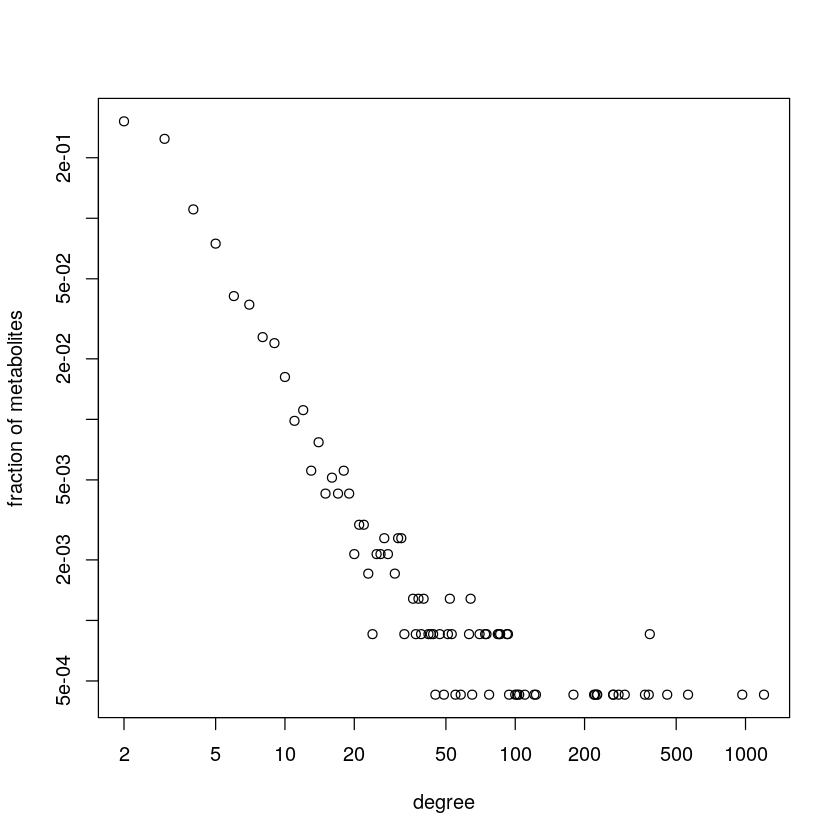

In [5]:
metab_degree_dist <- degree_distribution(bipartite_graph, 
                                         v=metabolite_inds)
kmax <- length(metab_degree_dist)
kvals <- 1:kmax
inds <- which(metab_degree_dist > 0)
plot(kvals[inds], metab_degree_dist[inds], log="xy",
     xlab="degree",
     ylab="fraction of metabolites")

Question* *What is the exponent α of the best-fit power-law?* 

(hint: use `power.law.fit` in igraph)

In [6]:
print(sprintf("%0.2f", power.law.fit(metabolite_degrees)$alpha))

[1] "2.02"


Questions to answer: How does the α that you get compare to the estimate of the power-law exponent reported by Jeong et al. in their 2000 article in Nature, “The large-scale organization of metabolic networks” (vol. 407, pp. 651–654) (see page 14 of reading-for-class-06.pdf)? Based on structure of the network that you analyzed (bipartite, containing reactions) vs. the structure of the network that they analyzed (network projected to a network containing only metabolites), is it appropriate to compare the exponents? Why or why not?

Your task: *Calculate the shortest-path-length between all pairs of metabolites (vertices) in the directed graph.*  

(hint: use `clusters` with `mode=weak` to get the giant weakly-connected component; get the component membership IDs for all metablites using the `membership` item of the components object; select metabolites that have component membership==1; then use `shortest.paths` with `mode=all`)

In [7]:
components <- clusters(bipartite_graph, mode="weak")
vertices_giant_component <- which(components$membership == 1)
vertices_metabs_giant_component <- intersect(metabolite_inds, vertices_giant_component)

metab_dists <- shortest.paths(bipartite_graph, v=vertices_metabs_giant_component,
                              mode="all",
                              to=vertices_metabs_giant_component)

Question: *What is the average of the shortest-path-length between all pairs of metabolites in the giant (weakly connected) component of the network?* 

(Note, you will want to throw away any shortest-paths distance value if it is infinite.)

In [8]:
print(sprintf("%0.2f", mean(metab_dists[metab_dists > 0 & metab_dists < Inf])))

[1] "6.80"


Question: *What is the maximum of the shortest-path-length between all pairs of metabolites (throwing away infinite values, as before) in the giant (weakly connected) component of the network?* 

(Note, you are calculating the diameter of the giant component).

In [9]:
print(max(metab_dists[metab_dists > 0 & metab_dists < Inf]))

[1] 18


Question: Why are the average geodesic distances that we get, roughly twice those reported in Fig. 3b of Jeong et al., 2000?

Your task: *Calculate the shortest-paths betweenness centrality for all metabolites in the network. Make sure you compute betweenness centrality only for metabolite vertices, and on the directed graph.* 

(hint: use the `betweenness` function with the `v=<vector of vertex indices>` option)

In [10]:
Nmetab <- length(metabolite_inds)
bc <- betweenness(bipartite_graph, v=metabolite_inds)/((Nmetab-1)*(Nmetab-2))

Your task: *plot the scatter plot of betweenness centrality vs. vertex degree for all metabolites, on log-log scale.*

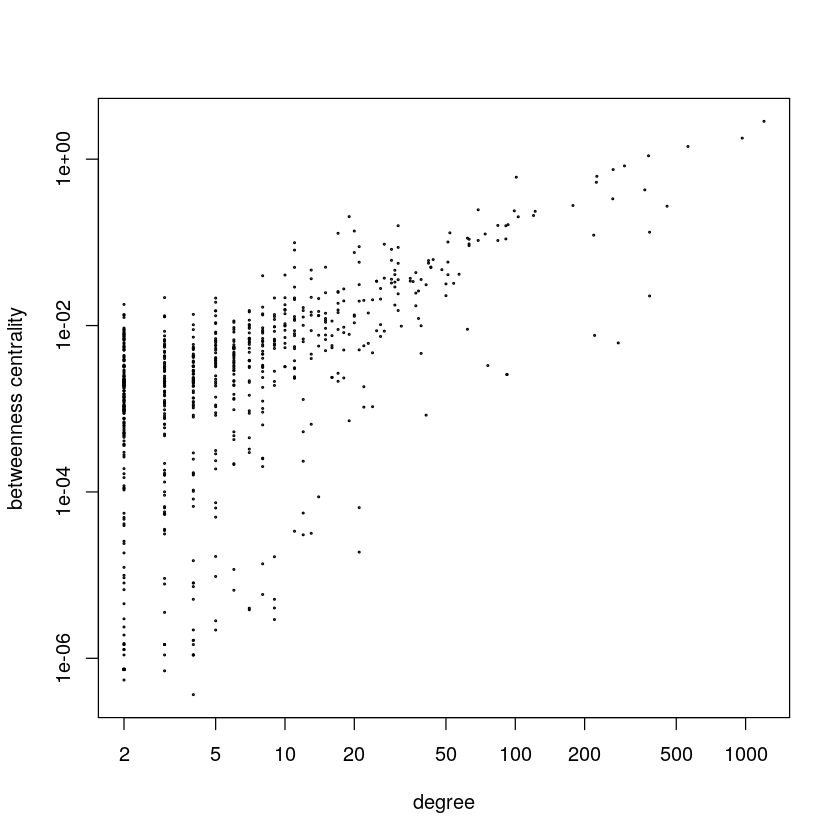

In [11]:
inds <- which(bc > 0)
plot(metabolite_degrees[inds], bc[inds], log="xy",
     xlab="degree",
     ylab="betweenness centrality", cex=0.2)

Question: *Among metabolites with degree k=2 , what metabolite has highest betweenness centrality in the network?* 

(hint:  use `sort` and `head`)

In [12]:
print(head(sort(bc[metabolite_degrees==2],decreasing=TRUE), n=1))

L-arginino-succinate 
          0.01794253 


Search on this metabolite in the HumanCyc database at [humancyc.org](https://humancyc.org), using the search box. Click on the "reactions" tab. What important metabolic cycles is this metabolite involved in? Click on the "urea cycle". What is the known consequence of absence of an enzyme in this pathway?